# NLP_Project_01 非监督文本自动摘要模型的构建

# Contects
* [Step 1 Data Preprocessing](#Step-1-Data-Preprocessing)
* [Sept 2 Data Modeling](#Sept-2-Data-Modeling)
* [Sept 3 Model optimizing](#Sept-3-Model-Optimizing)
* [Step 4 Data Visulization](#Sept-4-Data-Visulization)

## Step 1 Data Preprocessing

### Step 1-1 维基百科中文语料的处理
Corpus data
* Name: zhwiki
* Source: https://ftp.acc.umu.se/mirror/wikimedia.org/dumps/zhwiki/20191120/zhwiki-20191120-pages-articles-multistream.xml.bz2
* Tool: https://github.com/attardi/wikiextractor
* Usage tips: python WikiExtractor.py -b 500M -o zhwiki --json zhwiki-20191120-pages-articles-multistream.xml.bz2

Conversion from Traditional Chinese to Simplied Chinese
* Lib: OpenCC
* Source: https://github.com/BYVoid/OpenCC
* Install: pip install opencc-python-reimplemented

### Step 1-2 汉语新闻语料库的处理
Corpus data: 
* Name: 汉语新闻语料库
* Source: https://github.com/Computing-Intelligence/datasource/blob/master/export_sql_1558435.zip

### Step1-3: 使用Gensim训练词向量
Word2vec
* Lib: Gensim
* Intro: https://radimrehurek.com/gensim/models/word2vec.html
* Install: pip install gensim

### Step1-4: 测试词向量的效果
TSNE
* Lib: TSNE
* Intro: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
* Install: from sklearn.manifold import TSNE

### Step 1-1 维基百科中文语料的处理

#### Part 1 数据提取

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 16 14:34:35 2020

@author: Jerry
"""
# logging主要用于输出运行日志
import logging
import os.path
import sys
# optparse主要用于添加参数设置
from optparse import OptionParser
# gensim中专门处理WikiCorpus的类
from gensim.corpora import WikiCorpus

# 处理WikiCorpus函数，infile, outfile参数在需要在parser = OptionParser()中添加
def parse_corpus(infile, outfile):
    '''parse the corpus of the infile into the outfile'''
    space = ' '
    i = 0
    with open(outfile, 'w', encoding='utf-8') as fout:
        # gensim中的维基百科处理类WikiCorpus
        wiki = WikiCorpus(infile, lemmatize=False, dictionary={})  
        for text in wiki.get_texts():
            fout.write(space.join(text) + '\n')
            i += 1
            if i % 10000 == 0:
                logger.info('Saved ' + str(i) + ' articles')

# 程序主函数
def wiki_corpus_main():
    # 解析参数
    parser = OptionParser()
    # infile中default中添加wiki未处理过的压缩包文件名称
    parser.add_option('-i','--input',dest='infile',default='zhwiki-20191120-pages-articles-multistream.xml.bz2',help='input: Wiki corpus')
    # outfile为输出处理好的语料文件名称，默认corpus.zhwiki.txt
    parser.add_option('-o','--output',dest='outfile',default='01_corpus.zhwiki.txt',help='output: Wiki corpus')
    # 初始化args为空list，否则在jupyter notebook中会报错
    args = []
    # 读取parser中的参数
    (options,args) = parser.parse_args(args = [])

    infile = options.infile
    outfile = options.outfile

    try:
        # 处理语料parse_corpus函数，接收的参数为parser中的infile, outfile设置的参数
        parse_corpus(infile, outfile)
        logger.info('Finished Saved ' + str(i) + 'articles')
    except Exception as err:
        logger.info(err)
        
        
if __name__ == '__main__':
    # 返回当前运行的py文件名称
    program = os.path.basename(sys.argv[0])
    # logging.basicConfig函数中，可以指定日志的输出格式format，这个参数可以输出很多有用的信息
    # %(asctime)s: 打印日志的时间     %(levelname)s: 打印日志级别名称      %(message)s: 打印日志信息
    logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')
    # logging.getLogger(name)方法进行初始化，name可以不填。通常logger的名字我们对应模块名
    logger = logging.getLogger(program)  # logging.getLogger(logger_name)
    # logger.info打印程序运行是的正常的信息，用于替代print输出
    logger.info('running ' + program + ': parse the chinese corpus')
    # 运行程序主函数
    wiki_corpus_main()


#### Part 2 把WIKI数据里面的繁体字转成简体

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 16 16:17:37 2020

@author: Jerry
"""

import os, sys
import logging
# optparse主要用于添加参数设置
from optparse import OptionParser
# opencc主要处理中文繁体转简体，安装命令pip install opencc-python-reimplemented
from opencc import OpenCC


# 处理繁体转简体主函数，infile, outfile参数在需要在parser = OptionParser()中添加
def zh_wiki_t2s(infile, outfile):
    '''convert the traditional Chinese of infile into the simplified Chinese of outfile'''
    # 读取已提取的wiki语料txt文件
    t_corpus = []
    with open(infile,'r',encoding='utf-8') as f:
        for line in f:
            line = line.replace('\n', '').replace('\t','')
            t_corpus.append(line)
    logger.info('read traditional file finished!')

    # convert the t_Chinese to s_Chinese
    cc = OpenCC('t2s')
    s_corpus = []
    for i,line in zip(range(len(t_corpus)),t_corpus):
        if i % 1000 == 0:
            logger.info('convert t2s with the {}/{} line'.format(i,len(t_corpus)))
        # s_corpus.append(OpenCC.convert(line))
        s_corpus.append(cc.convert(line))
    logger.info('convert t2s finished!')

    # 把已转换为简体的s_corpus，写入输出文件
    with open(outfile, 'w', encoding='utf-8') as f:
        for line in s_corpus:
            f.writelines(line + '\n')
    logger.info('write the simplified file finished!')

# 程序主函数
def t2s_main():   
    # 解析参数
    parser = OptionParser()
    # infile中default中添加wiki在步骤一中已经提取的txt文件
    parser.add_option('-i','--input',dest='input_file',default='01_corpus.zhwiki.txt',help='traditional file')
    # outfile为输出处理好的繁体转简体文件名称，默认corpus.zhwiki.simplified.txt
    parser.add_option('-o','--output',dest='output_file',default='02_corpus.zhwiki.simplified.txt',help='simplified file')
    # 初始化args为空list，否则在jupyter notebook中会报错
    args = []
    # 读取parser中的参数
    (options,args) = parser.parse_args(args = [])
    
    input_file = options.input_file
    output_file = options.output_file

    try:
        # 处理语料zh_wiki_t2s函数，接收的参数为parser中的infile, outfile设置的参数
        zh_wiki_t2s(infile=input_file,outfile=output_file)
        logger.info('Traditional Chinese to Simplified Chinese Finished')
    except Exception as err:
        logger.info(err)
        
        
if __name__ == '__main__':
    # 返回当前运行的py文件名称
    program = os.path.basename(sys.argv[0])
    # logging.getLogger(name)方法进行初始化，name可以不填。通常logger的名字我们对应模块名
    logger = logging.getLogger(program)
    # logging.basicConfig函数中，可以指定日志的输出格式format，这个参数可以输出很多有用的信息
    # %(asctime)s: 打印日志的时间     %(levelname)s: 打印日志级别名称      %(message)s: 打印日志信息
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    # logger.info打印程序运行是的正常的信息，用于替代print输出
    logger.info('running ' + program + ' : convert Traditional Chinese to Simplified Chinese')
    # 运行程序主函数
    t2s_main()

#### Part 3 把WIKI数据里面的英文字符和空格空行去掉

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 16 17:06:04 2020

@author: Jerry
"""

import os, sys
import logging
from optparse import OptionParser
import re

# 处理去掉语料中英文、空格和多余字符主函数，infile, outfile参数在需要在parser = OptionParser()中添加
def remove_en_blank(infile,outfile):
    '''remove the english word and blank from infile, and write into outfile'''
    with open(infile,'r',encoding='utf-8') as fin, open(outfile,'w',encoding='utf-8') as fout:
        relu1 = re.compile(r'[ a-zA-Z]')  # delete english char and blank
        relu2 = re.compile(r'-\{.*?(zh-hans|zh-cn):([^;]*?)(;.*?)?\}-')
        relu3 = re.compile(r'[（\(][，；。？！\s]*[）\)]')
        relu4 = re.compile(r'[「『]')
        relu5 = re.compile(r'[」』]')

        i = 0
        for line in fin:
            res = relu1.sub('', line)
            res = relu2.sub('\2', line)
            res = relu3.sub('', line)
            res = relu4.sub('“', line)
            res = relu5.sub('”', line)          
            fout.write(res)
            i += 1
            if i % 1000 == 0:
                logger.info('handing with the {} line'.format(i))

# 程序主函数
def remove_en_blank_main():
    # 解析参数
    parser = OptionParser()
    # infile中default中添加wiki处理过的繁体转简体的txt文件名称
    parser.add_option('-i','--input',dest='infile',default='02_corpus.zhwiki.simplified.txt',help='input file to be preprocessed')
    # outfile为输出处理好的语料文件名称，默认corpus.zhwiki.simplified.done.txt
    parser.add_option('-o','--output',dest='outfile',default='03_corpus.zhwiki.simplified.done.txt',help='output file removed english and blank')
    # 初始化args为空list，否则在jupyter notebook中会报错
    args = []
    # 读取parser中的参数
    (options,args) = parser.parse_args(args = [])

    infile = options.infile
    outfile = options.outfile

    try:
        # 处理语料remove_en_blank函数，接收的参数为parser中的infile, outfile设置的参数
        remove_en_blank(infile, outfile)
        logger.info('remove english and blank finished')
    except Exception as err:
        logger.info(err)    
    
    
if __name__ == '__main__':
    # 返回当前运行的py文件名称
    program = os.path.basename(sys.argv[0])
    # logging.basicConfig函数中，可以指定日志的输出格式format，这个参数可以输出很多有用的信息
    # %(asctime)s: 打印日志的时间     %(levelname)s: 打印日志级别名称      %(message)s: 打印日志信息
    logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')
    # logging.getLogger(name)方法进行初始化，name可以不填。通常logger的名字我们对应模块名
    logger = logging.getLogger(program)  # logging.getLogger(logger_name)
    # logger.info打印程序运行是的正常的信息，用于替代print输出
    logger.info('running ' + program + ': remove english and blank')    
    # 运行程序主函数
    remove_en_blank_main()
    

#### Part 4 把WIKI数据做分词处理（注意：不需要去掉停用词）

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 16 18:22:53 2020

@author: Jerry
"""

import os, sys
import logging
from optparse import OptionParser
import jieba
import os 
import sys

# 创建停用词列表，chinese_stopwords中有常用的中文停用词1800多个
def getStopwords():
    stopwords = [line.strip() for line in open('chinese_stopwords.txt',encoding='UTF-8').readlines()]
    return stopwords

# 中文分词及去中文停用词主函数
def seg_with_jieba(infile, outfile,stopword=False):
    '''segment the input file with jieba'''
    with open(infile, 'r', encoding='utf-8') as fin, open(outfile, 'w', encoding='utf-8') as fout:
        i = 0       
        for line in fin:
            # jieba分词
            seg_list = jieba.cut(line)           
            sentence_segment=[] 
            # 遍历seg_list
            for word in seg_list:
                if stopword: 
                    # 判断word不在停用词列表中才执行append
                    if word not in stopwords:
                        sentence_segment.append(word)
                sentence_segment.append(word)        
            # 把已去掉停用词的sentence_segment，用' '.join()拼接起来
            seg_res = ' '.join(sentence_segment)
            # 把拼接好的分词结果，写入output文件
            fout.write(seg_res)
            i += 1
            if i % 1000 ==0:
                logger.info('handing with {} line'.format(i))

# 程序主函数
def seg_with_jieba_main():
    # # 解析参数
    parser = OptionParser()
    # infile中default中添加wiki已处理繁体转简体，并去除多余字符的txt文件名称
    parser.add_option('-i','--input',dest='infile',default='03_corpus.zhwiki.simplified.done.txt',help='input file to be segmented')
    # outfile为输出处理好的语料文件名称，默认corpus.zhwiki.segwithb.txt
    parser.add_option('-o','--output',dest='outfile',default='04_corpus.zhwiki.segwithb.txt',help='output file segmented')
    # 初始化args为空list，否则在jupyter notebook中会报错
    args = []
    # 读取parser中的参数
    (options,args) = parser.parse_args(args = [])
    infile = options.infile
    outfile = options.outfile

    try:
        # 处理语料seg_with_jieba函数，接收的参数为parser中的infile, outfile设置的参数
        seg_with_jieba(infile,outfile)
        logger.info('segment the infile finished')
    except Exception as err:
        logger.info(err)    

if __name__ == '__main__':
        # 返回当前运行的py文件名称
    program = os.path.basename(sys.argv[0])
    # logging.basicConfig函数中，可以指定日志的输出格式format，这个参数可以输出很多有用的信息
    # %(asctime)s: 打印日志的时间     %(levelname)s: 打印日志级别名称      %(message)s: 打印日志信息
    logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')
    # logging.getLogger(name)方法进行初始化，name可以不填。通常logger的名字我们对应模块名
    logger = logging.getLogger(program)  # logging.getLogger(logger_name)
    # logger.info打印程序运行是的正常的信息，用于替代print输出
    logger.info('running ' + program + ': segmentation of corpus by jieba')
    # 获取中文停用词列表
    stopwords = getStopwords()
    
    # 运行程序主函数
    seg_with_jieba_main()

### Step 1-2 汉语新闻语料库的处理

#### Part 5 读取新闻语料，去掉多余字符和空行，并做分词处理

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 17 12:44:00 2020

@author: Jerry
"""

import os, sys
import logging
from optparse import OptionParser
import jieba
import os 
import re
import sys
import pandas as pd

# 读取新闻语料函数
def read_news_data():
    # 用pd.read_csv方法读取新闻语料
    df = pd.read_csv('sqlResult_1558435.csv',encoding = 'utf-8')
    # 把新闻语料中的content列，单独保存为corpus.news.txt
    df['content'].to_csv('corpus.news.txt',header=None,index=None)
    
    
# 创建停用词列表，chinese_stopwords中有常用的中文停用词1800多个
def getStopwords():
    stopwords = [line.strip() for line in open('chinese_stopwords.txt',encoding='UTF-8').readlines()]
    return stopwords

# 新闻语料，中文分词及去中文停用词主函数
def seg_with_jieba(infile, outfile,stopword=False):
    '''segment the input file with jieba'''
    with open(infile, 'r', encoding='utf-8') as fin, open(outfile, 'w', encoding='utf-8') as fout:
        relu1 = re.compile(r'[ a-zA-Z]')  # delete english char and blank
        relu2 = re.compile(r'-\{.*?(zh-hans|zh-cn):([^;]*?)(;.*?)?\}-')
        relu3 = re.compile(r'[（\(][，；。？！\s]*[）\)]')
        relu4 = re.compile(r'[「『]')
        relu5 = re.compile(r'[」』]')                
        i = 0      
        
        for line in fin:
            res = relu1.sub('', line)
            res = relu2.sub('\2', line)
            res = relu3.sub('', line)
            res = relu4.sub('“', line)
            res = relu5.sub('”', line) 
            # jieba分词
            seg_list = jieba.cut(line)            
            sentence_segment=[] 
            # 判断行里不为"
            if seg_list !='"':
                for word in seg_list:
                    if stopword:                        
                        # 判断word不在停用词列表中才执行append
                        if word not in stopwords:
                            sentence_segment.append(word)
                    sentence_segment.append(word)        
                # 把已去掉停用词的sentence_segment，用' '.join()拼接起来
                seg_res = ' '.join(sentence_segment)
                # 把拼接好的分词结果，写入output文件
                fout.write(seg_res)
                i += 1
                if i % 1000 ==0:
                    logger.info('handing with {} line'.format(i))


# 由于去除多余字符后，分词文件有许多空行，现在要去掉除语料中的空行
def remove_blank_lines(outfile,new_outfile):
    with open('corpus.news.segwithb_temp.txt','r',encoding = 'utf-8') as fr,open('05_corpus.news.segwithb.txt','w',encoding = 'utf-8') as fd:
        for text in fr.readlines():            
            if text.strip().split():
                    fd.write(text)
    print('输出成功....')

    
# 新闻语料主函数
def news_seg_main():
    # 解析参数
    parser = OptionParser()
    # infile中default中添加新闻语料txt文件名称，该文件在read_data()函数中产生
    parser.add_option('-i','--input',dest='infile',default='corpus.news.txt',help='input file to be segmented')
    # 临时存储已去掉多余字符的分词txt文件
    parser.add_option('-o','--output',dest='outfile',default='corpus.news.segwithb_temp.txt',help='output file segmented')
    # 输出处理好的分词文件，默认corpus.news.segwithb.txt
    parser.add_option('-n','--new_output',dest='new_outfile',default='05_corpus.news.segwithb.txt',help='new_output file segmented')
    # 初始化args为空list，否则在jupyter notebook中会报错
    args = []
    # 读取parser中的参数
    (options,args) = parser.parse_args(args = [])
    
    infile = options.infile
    outfile = options.outfile
    new_outfile = options.new_outfile
    # 读取新闻语料
    read_news_data()
    # 获取中文停用词列表
    stopwords = getStopwords()
    try:
        # 处理语料seg_with_jieba函数，接收的参数为parser中的infile, outfile设置的参数
        seg_with_jieba(infile,outfile)
        # 运行去空行函数
        remove_blank_lines(outfile,new_outfile)
        logger.info('segment the infile finished')
    except Exception as err:
        logger.info(err)    
    
if __name__ == '__main__':
    # 返回当前运行的py文件名称
    program = os.path.basename(sys.argv[0])
    # logging.basicConfig函数中，可以指定日志的输出格式format，这个参数可以输出很多有用的信息
    # %(asctime)s: 打印日志的时间     %(levelname)s: 打印日志级别名称      %(message)s: 打印日志信息
    logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')
    # logging.getLogger(name)方法进行初始化，name可以不填。通常logger的名字我们对应模块名
    logger = logging.getLogger(program)  # logging.getLogger(logger_name)
    # logger.info打印程序运行是的正常的信息，用于替代print输出
    logger.info('running ' + program + ': segmentation of corpus by jieba')
    news_seg_main()
    

#### Part 6 合拼Wiki和新闻语料

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 17 14:16:35 2020

@author: Jerry
"""

import pandas as pd

# 把处理好的中文wiki和新闻语料合拼到txt中
def concat_txt():
    # 读取中文wiki语料
    corpus_zhwiki = pd.read_csv('04_corpus.zhwiki.segwithb.txt',names='content')  
    # 读取新闻语料
    corpus_news = pd.read_csv('05_corpus.news.segwithb.txt',names='content')    
    # 用pd.concat把两个dataframe合拼一起
    corpus_zhwiki_news = pd.concat([corpus_zhwiki, corpus_news])    
    # 删除corpus_zhwiki, corpus_news以免占用内存
    del corpus_zhwiki, corpus_news
    # 输入合拼后的文件corpus.zhwiki_news.segwithb.txt，该文件可以直接用于训练词向量
    corpus_zhwiki_news.to_csv('06_corpus.zhwiki_news.segwithb.txt',header=None,index=None)


if __name__ == '__main__':
    concat_txt()


### Step1-3: 使用Gensim训练词向量

#### Part 7 把合拼后的语料，用gensim训练词向量

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 16 17:16:29 2020

@author: Jerry
"""

import os, sys
import logging
import multiprocessing
from optparse import OptionParser
from gensim.corpora import WikiCorpus
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

# word2vec训练词向量模型函数
def word2vec_train(infile,outmodel,outvector,size,window,min_count):
    '''train the word vectors by word2vec'''
    
    # 训练模型
    model = Word2Vec(LineSentence(infile),size=size,window=window,min_count=min_count,sg=sg,workers=multiprocessing.cpu_count())

    # 保存模型
    model.save(outmodel)
    model.wv.save_word2vec_format(outvector,binary=False)


# word2vec程序主函数
def word2vec_train_main():
    # 解析参数
    parser = OptionParser()
    # infile中default中添加需要训练词向量的txt文件名称
    parser.add_option('-i','--input',dest='infile',default='06_corpus.zhwiki_news.segwithb.txt',help='zhwiki corpus')
    # 设置保存模型的参数
    parser.add_option('-m','--outmodel',dest='wv_model',default='zhwiki_news.word2vec.model',help='word2vec model')
    parser.add_option('-v','--outvec',dest='wv_vectors',default='zhwiki_news.word2vec.vectors',help='word2vec vectors')
    # 设置训练模型的参数size，是指特征向量的维度，默认为100。大的size需要更多的训练数据,但是效果会更好
    parser.add_option('-s',type='int',dest='size',default=600,help='word vector size')
    # 设置训练模型的参数window，表示当前词与预测词在一个句子中的最大距离是多少,默认值为5
    parser.add_option('-w',type='int',dest='window',default=10,help='window size')
    # 设置训练模型的参数min_count，可以对字典做截断. 词频少于min_count次数的单词会被丢弃掉, 默认值为5
    parser.add_option('-n',type='int',dest='min_count',default=5,help='min word frequency')
    # 设置训练模型的参数sg，用于设置训练算法，默认为0，对应CBOW算法；sg=1则采用skip-gram算法。
    parser.add_option('-sg',type='int',dest='sg',default=1,help='sg')
    
    # 初始化args为空list，否则在jupyter notebook中会报错
    args = []
    # 读取parser中的参数
    (options,args) = parser.parse_args(args = [])

    infile = options.infile
    outmodel = options.wv_model
    outvec = options.wv_vectors
    vec_size = options.size
    window = options.window
    min_count = options.min_count

    try:       
        word2vec_train(infile, outmodel, outvec, vec_size, window, min_count)
        logger.info('word2vec model training finished')
    except Exception as err:
        logger.info(err)    
    
       
if __name__ == '__main__':
    # 返回当前运行的py文件名称
    program = os.path.basename(sys.argv[0])
    # logging.basicConfig函数中，可以指定日志的输出格式format，这个参数可以输出很多有用的信息
    # %(asctime)s: 打印日志的时间     %(levelname)s: 打印日志级别名称      %(message)s: 打印日志信息
    logging.basicConfig(level = logging.INFO, format = '%(asctime)s - %(levelname)s - %(message)s')
    # logging.getLogger(name)方法进行初始化，name可以不填。通常logger的名字我们对应模块名
    logger = logging.getLogger(program)  # logging.getLogger(logger_name)
    # logger.info打印程序运行是的正常的信息，用于替代print输出
    logger.info('running ' + program)    
    # 运行程序主函数
    word2vec_train_main()

### Step1-4: 测试词向量的效果

#### Part 1 词向量的语义相似性测试

In [1]:
from gensim.models import Word2Vec
import os
os.chdir(r'D:\1-开课吧\05-项目\项目01')

F:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
WORD2VEC_MODEL_DIR = './1zhwiki_news.word2vec.model'

word2vec_model = Word2Vec.load(WORD2VEC_MODEL_DIR)

In [3]:
# 查看词向量
vec = word2vec_model.wv['北京']
print('北京：', vec)

北京： [ 2.04273209e-01 -2.48872429e-01  1.15639612e-01 -1.41946107e-01
  1.45101294e-01  7.27584586e-02  1.62805244e-01 -3.82012650e-02
  4.20679420e-01  1.69035226e-01 -3.86518419e-01 -2.25332052e-01
 -1.24380708e-01  1.55338600e-01 -2.92920992e-02 -1.24443635e-01
 -3.36482539e-03  1.49807245e-01  1.27348453e-02  5.74214123e-02
 -4.48872931e-02  1.24181546e-01 -8.97520259e-02 -1.29088119e-01
 -2.73578372e-02  2.85427243e-01 -3.12323719e-01  7.31676519e-02
  1.92926690e-01  1.59240682e-02  8.19974616e-02  1.30899280e-01
  1.09848790e-01  3.16178016e-02 -7.76914433e-02 -3.21194828e-02
  1.99867234e-01  2.62754798e-01 -1.88430637e-01  1.28828930e-02
 -4.84617315e-02 -1.70903429e-01 -2.28285685e-01 -6.77329600e-02
  4.88636494e-01 -3.71495634e-02 -2.68161446e-01 -1.13091886e-01
 -4.14000601e-01 -1.79579094e-01 -2.40848199e-01  2.67486364e-01
 -1.88744351e-01 -1.46115020e-01 -1.59289464e-01  1.78735033e-02
 -2.18718365e-01  2.12752059e-01 -3.76135632e-02  6.24105223e-02
 -3.29435408e-01  3.6

In [4]:
# 查看相似词
sim_words = word2vec_model.wv.most_similar('勇敢')
print('The most similar words: ')
for w in sim_words:
    print(w)

The most similar words: 
('勇气', 0.556270956993103)
('娜碧拉', 0.522657036781311)
('善良', 0.5116276741027832)
('越挫', 0.5100153684616089)
('坚强', 0.5050840973854065)
('勇敢无畏', 0.4921317398548126)
('勇敢的人', 0.4880952537059784)
('康襄维', 0.48494359850883484)
('不怕苦', 0.4847092628479004)
('过硬本领', 0.4843388795852661)


In [5]:
# 查看相似词
sim_words = word2vec_model.wv.most_similar('美女')
print('The most similar words: ')
for w in sim_words:
    print(w)  

The most similar words: 
('性感', 0.5272769927978516)
('野兽', 0.5105139017105103)
('大吐槽', 0.4990156888961792)
('人窝', 0.4925405979156494)
('混血美女', 0.4918791949748993)
('刘宜萍', 0.48761749267578125)
('变宅', 0.4869961738586426)
('骗赞', 0.4823368787765503)
('大萌', 0.4753979444503784)
('猜得出', 0.4749506115913391)


In [6]:
word2vec_model.wv.similarity('中国', '美国')

0.536464248799442

#### Part 2 词向量的语义线性关系测试

In [7]:
def analogy(x1,x2,y1):
    result = word2vec_model.wv.most_similar(positive = [y1,x2],negative = [x1])
    #result
    return result

In [8]:
analogy('中国','汉语','美国')

[('英语', 0.41689109802246094),
 ('特朗普', 0.4109618365764618),
 ('西班牙语', 0.4068485498428345),
 ('俄语', 0.4024694859981537),
 ('夏安语', 0.3977389335632324),
 ('意地绪语', 0.3908803462982178),
 ('奇波安语', 0.3865017294883728),
 ('小松洋', 0.38615572452545166),
 ('德语', 0.3857205808162689),
 ('希呐', 0.3824836313724518)]

In [9]:
analogy('美国','奥巴马','美国')[0][0]

'特朗普'

#### Part 3 词向量的可视化

In [70]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import random
# 解决matplotlib中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

In [81]:
# 因为词向量文件比较大，全部可视化就什么都看不见了，所以随机抽取一些词可视化
def visualizing_word_vectors(n = 500):    
    # 加载词向量字典
    words = list(word2vec_model.wv.vocab)
    # 把字典的顺序打乱
    random.shuffle(words)
    # 取前n个词
    vector = word2vec_model.wv[words[:n]]
    # 用TSNE降维，降低为二维，使用PCA方法
    tsne = TSNE(n_components=2,init='pca',verbose=1)
    emb = tsne.fit_transform(vector)
    # 可视化词向量过程，设置画布大小
    plt.figure(figsize=(14,10))
    # 取cmap中gist_ncar颜色
    colors = plt.cm.gist_ncar(np.linspace(0, 1, n))
    # 绘制散点图
    plt.scatter(emb[:,0], emb[:,1],marker = 'o',color = colors,s = 50,alpha = 0.5)
    for i in range(n):
        x = emb[i][0]
        y = emb[i][1]
        plt.text(x, y, words[i],alpha = 0.8)
    plt.show() 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.009s...
[t-SNE] Computed neighbors for 500 samples in 0.293s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.972007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.184067
[t-SNE] KL divergence after 1000 iterations: 1.260910


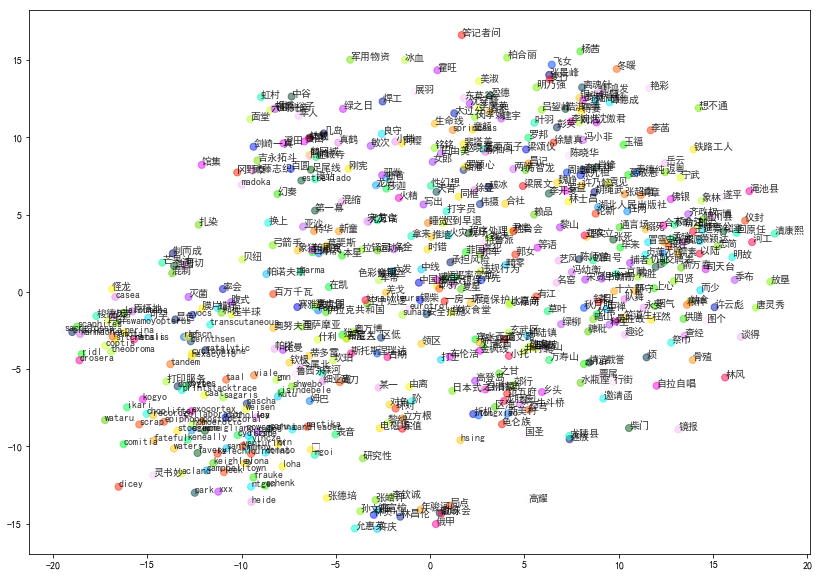

In [83]:
# 运行可视化函数
visualizing_word_vectors(n = 500)